In [1]:
import pandas as pd

# Загрузка данных
train_df = pd.read_csv("t1_data_train.tsv", sep="\t")
test_df = pd.read_csv("t1_data_test.tsv", sep="\t")

# Просмотр первых строк обучающего набора
print("Train data head:")
print(train_df.head())

# Если тестовый набор не содержит меток:
print("\nTest data head:")
print(test_df.head())


Train data head:
   id                                               text  class_label
0   0                                   Great initiative            0
1   1  ....This app activating ; then Blootooth all w...            1
2   2  I am fully supportive of this app and want it ...            0
3   3  Once you registered in absher you cannot regis...            1
4   4  The app keeps stopping. Pls fix this I'll chan...            2

Test data head:
   id                                               text  class_label
0   0  The app keeps deactivating on its own and you ...            2
1   1                                 Not much effective            1
2   2  Simple app, easy to activate and could save li...            0
3   3               Its a great app. U can save yourself            0
4   4                                           Good app            0


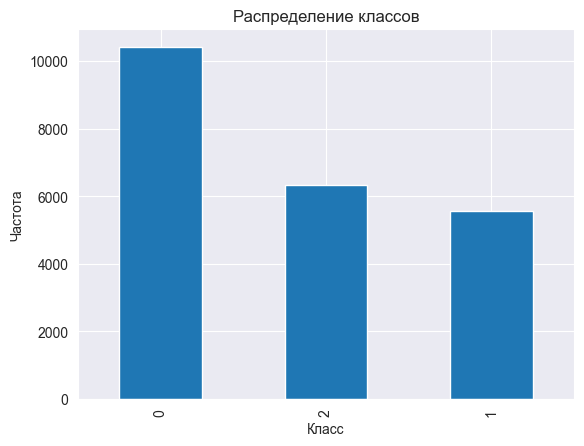

In [2]:
import matplotlib.pyplot as plt

train_df['class_label'].value_counts().plot(kind='bar')
plt.title("Распределение классов")
plt.xlabel("Класс")
plt.ylabel("Частота")
plt.show()


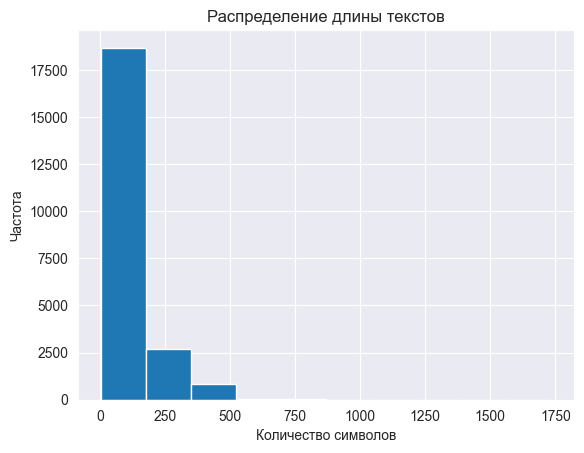

In [3]:
# Добавляем столбец длины текста (количество символов или слов)
train_df['text_length'] = train_df['text'].apply(len)

plt.hist(train_df['text_length'], bins=10)
plt.title("Распределение длины текстов")
plt.xlabel("Количество символов")
plt.ylabel("Частота")
plt.show()


# Извлечение эмбеддингов с использованием multilingual-e5-large-instruct
Получаем векторное представление текстов с помощью модели с Hugging Face

In [4]:
from transformers import AutoTokenizer, AutoModel
import torch

# Определение устройства: GPU, если доступно
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Инициализация токенизатора и модели
tokenizer = AutoTokenizer.from_pretrained("intfloat/multilingual-e5-small")
model = AutoModel.from_pretrained("intfloat/multilingual-e5-small").to(device)

def get_embedding(text):
    # Токенизация
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    
    # Перенос входных тензоров на нужное устройство
    inputs = {key: val.to(device) for key, val in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
        emb = outputs.last_hidden_state.mean(dim=1)
    
    return emb.squeeze().cpu().numpy()

# Извлечение эмбеддингов для обучающего набора
train_df['embedding'] = train_df['text'].apply(get_embedding)
# Извлечение эмбеддингов для тестового набора
test_df['embedding'] = test_df['text'].apply(get_embedding)

In [5]:
import numpy as np

# Получаем список эмбеддингов и превращаем его в numpy-массив
X = np.vstack(train_df['embedding'])
y = train_df['class_label'].values 

In [6]:
from sklearn.model_selection import train_test_split

# Разбиение данных на обучающую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Определение гиперпараметров для поиска
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # Для использования L1
}

lr = LogisticRegression()
grid_lr = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy')
grid_lr.fit(X_train, y_train)

print("Лучшая конфигурация LR:", grid_lr.best_params_)
print("Точность на валидации:", grid_lr.score(X_val, y_val))


Лучшая конфигурация LR: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Точность на валидации: 0.8351278600269179


F1-score (LR): 0.8335416042647971

Classification Report (LR):
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      2083
           1       0.77      0.66      0.71      1111
           2       0.75      0.82      0.78      1264

    accuracy                           0.84      4458
   macro avg       0.81      0.81      0.81      4458
weighted avg       0.84      0.84      0.83      4458



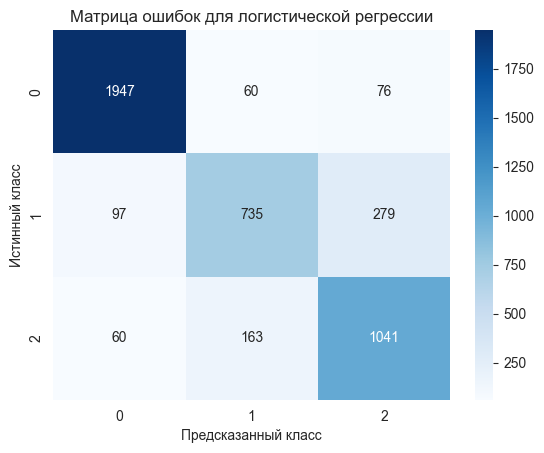

In [8]:
# расчёт F1-score и построения матрицы ошибок для логистической регрессии:
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_lr = grid_lr.predict(X_val)
print("F1-score (LR):", f1_score(y_val, y_pred_lr, average='weighted'))
print("\nClassification Report (LR):\n", classification_report(y_val, y_pred_lr))

cm = confusion_matrix(y_val, y_pred_lr)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Матрица ошибок для логистической регрессии")
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.show()


## Проверяем модель на тестовых данных

In [9]:
# Преобразуем список эмбеддингов тестового набора в numpy массив
X_test = np.vstack(test_df['embedding'])
y_test = test_df['class_label'].values

Точность модели на тестовом наборе: 0.8326500865445933

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      5177
           1       0.75      0.65      0.70      2622
           2       0.75      0.81      0.78      3178

    accuracy                           0.83     10977
   macro avg       0.81      0.80      0.80     10977
weighted avg       0.83      0.83      0.83     10977



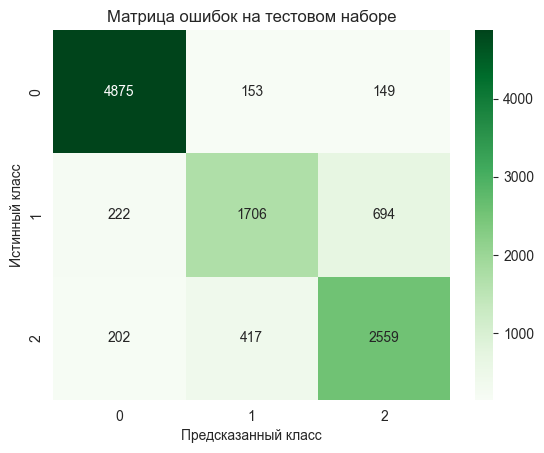

In [10]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Получаем предсказания модели на тестовых данных
y_pred_test = grid_lr.predict(X_test)

# Оценка точности на тестовом наборе
test_accuracy = accuracy_score(y_test, y_pred_test)
print("Точность модели на тестовом наборе:", test_accuracy)

# Подробный отчёт по метрикам
print("\nClassification Report (Test):")
print(classification_report(y_test, y_pred_test))

# Построение матрицы ошибок для тестового набора
cm_test = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Greens")
plt.title("Матрица ошибок на тестовом наборе")
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.show()
